In [1]:
# Cell 1: Basic imports and device setup
import torch
from pytorch3d.utils import ico_sphere
from pytorch3d.io import save_obj
import matplotlib.pyplot as plt
from tqdm import tqdm

# Use CPU for stable execution
device = torch.device("cpu")

In [2]:
# Cell 2: Initialize the mesh and model
src_mesh = ico_sphere(3, device)  # Reduced complexity from 4 to 3
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, requires_grad=True)
optimizer = torch.optim.Adam([deform_verts], lr=0.01)  # Reduced learning rate

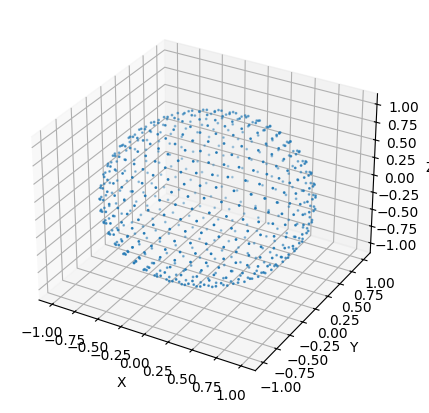

In [3]:
# Cell 3: Simplified visualization
def visualize_mesh(mesh):
    verts = mesh.verts_packed().detach().cpu().numpy()
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], s=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Initial visualization
visualize_mesh(src_mesh)

  0%|                                                            | 0/100 [00:00<?, ?it/s]


Iteration 0, Loss: 0.022815


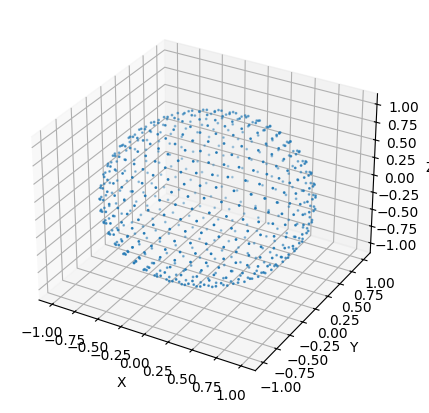

 14%|███████                                           | 14/100 [00:00<00:00, 139.19it/s]


Iteration 20, Loss: 0.012939


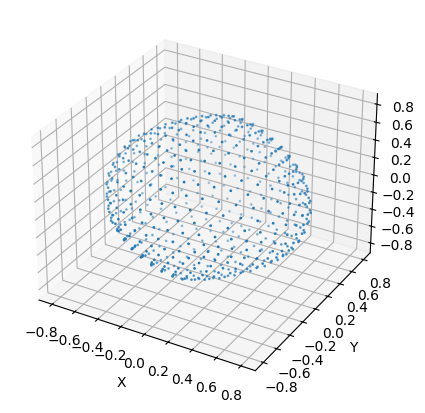

 28%|██████████████                                    | 28/100 [00:00<00:00, 120.83it/s]


Iteration 40, Loss: 0.006636


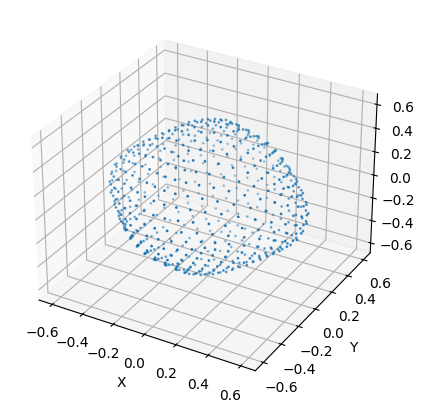


Iteration 60, Loss: 0.003044


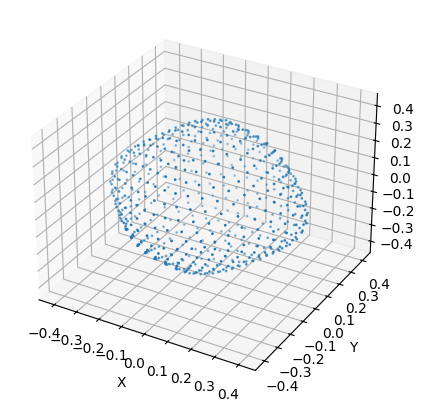

 61%|██████████████████████████████▌                   | 61/100 [00:00<00:00, 181.88it/s]


Iteration 80, Loss: 0.001228


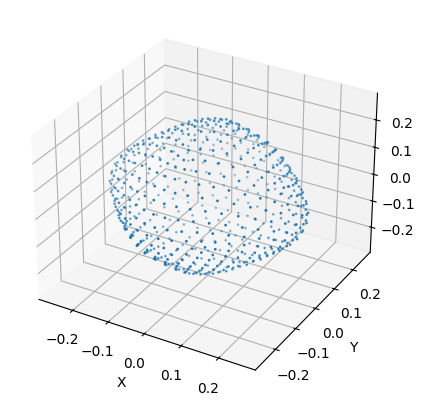

100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 228.31it/s]


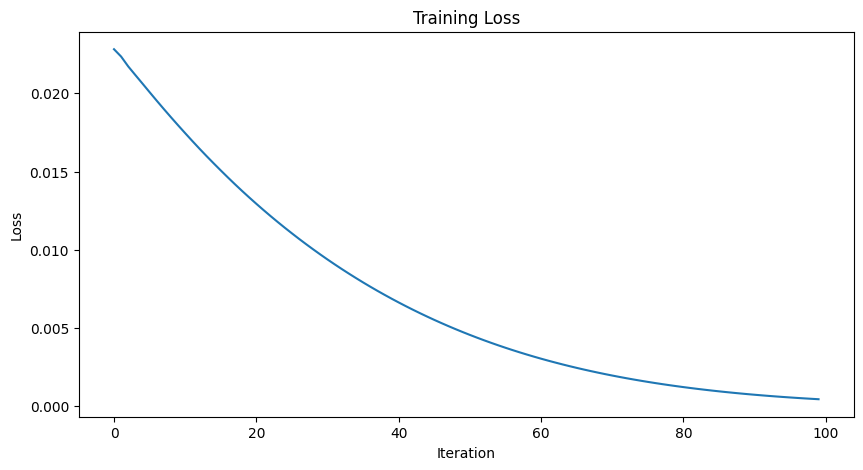

In [5]:
# Cell 4: Simplified training loop
from pytorch3d.loss import mesh_edge_loss
n_iterations = 100  # Reduced number of iterations

losses = []
try:
    for i in tqdm(range(n_iterations)):
        optimizer.zero_grad()
        
        # Deform mesh
        new_mesh = src_mesh.offset_verts(deform_verts)
        
        # Simple edge length loss
        loss = mesh_edge_loss(new_mesh)
        
        # Save loss value
        losses.append(loss.item())
        
        # Optimization step
        loss.backward()
        optimizer.step()
        
        # Periodic visualization
        if i % 20 == 0:
            print(f"\nIteration {i}, Loss: {loss.item():.6f}")
            visualize_mesh(new_mesh)
        
        # Clear memory
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
except Exception as e:
    print(f"Error occurred: {str(e)}")

# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [6]:
# Cell 5: Save the result
try:
    final_verts = src_mesh.offset_verts(deform_verts).verts_packed().detach()
    final_faces = src_mesh.faces_packed()
    
    save_obj(
        f='final_mesh.obj',
        verts=final_verts,
        faces=final_faces
    )
    print("Mesh saved successfully!")
except Exception as e:
    print(f"Error saving mesh: {str(e)}")

Mesh saved successfully!
